Loaded: data/benchmark-all-layers.csv
Shape: (5443, 6)
Columns: ['id', 'height', 'height_geoalert-tuned', 'height_geoalert-default', 'height_GBF', 'height_GBA']

Columns: ['height_geoalert-tuned', 'height_geoalert-default', 'height_GBF', 'height_GBA']

=== Metrics (filtered, ranked by MAE) ===


,prediction_col,samples,pearson_r,r2,mae_m,rmse_m,pred_mean,gt_mean,near_constant
0,height_geoalert-tuned,4614,0.900837,0.809367,4.652115,8.734258,18.455137,18.059991,False
1,height_geoalert-default,4595,0.848648,0.618980,6.589219,12.052458,13.425854,17.836518,False
2,height_GBA,4480,0.783751,0.457262,9.108359,14.949489,13.123870,18.405783,False
3,height_GBF,4381,0.605030,0.359750,10.870029,15.578299,19.071256,17.592513,False



=== Metrics (all numeric cols; includes id-like / constants) ===


,prediction_col,samples,pearson_r,r2,mae_m,rmse_m,pred_mean,gt_mean,near_constant
0,height_geoalert-tuned,4614,0.900837,0.809367,4.652115,8.734258,18.455137,18.059991,False
1,height_geoalert-default,4595,0.848648,0.618980,6.589219,12.052458,13.425854,17.836518,False
2,height_GBA,4480,0.783751,0.457262,9.108359,14.949489,13.123870,18.405783,False
3,height_GBF,4381,0.605030,0.359750,10.870029,15.578299,19.071256,17.592513,False



Best by MAE:
{'prediction_col': 'height_geoalert-tuned', 'samples': 4614, 'pearson_r': 0.9008373720920096, 'r2': 0.8093673084550537, 'mae_m': 4.6521153012570435, 'rmse_m': 8.734257578063824}


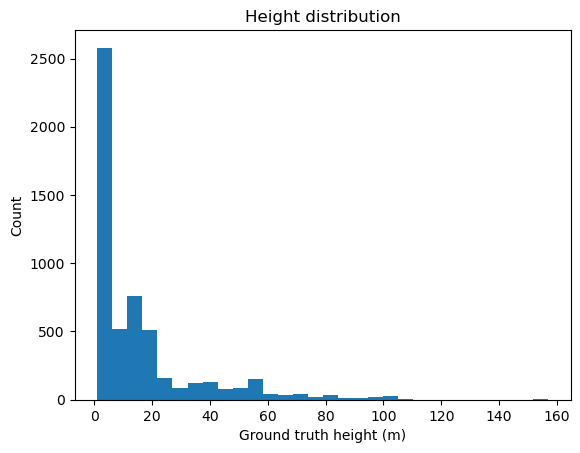

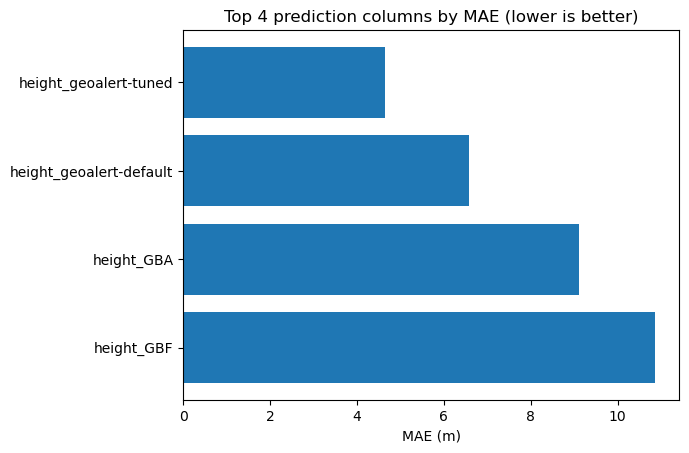

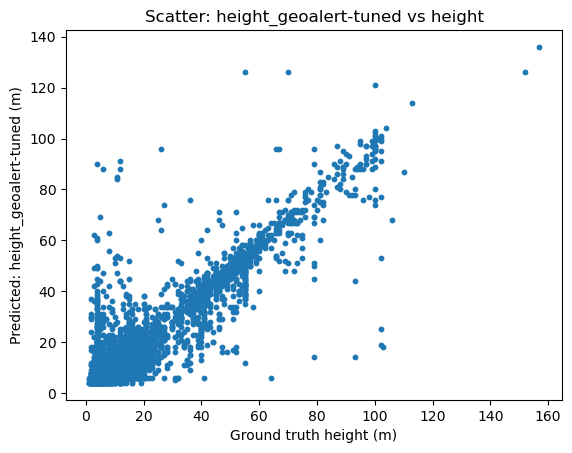


Saved filtered metrics to: data/benchmark-all-layers_metrics.csv


In [10]:
# Benchmark-all-layers analysis notebook
# File: data/benchmark-all-layers.csv
#
# What it does:
# 1) Loads the CSV
# 2) "height" as ground truth
# 3) Computes Pearson r, R², MAE, RMSE for every other numeric column
# 4) Shows rankings + optional plots

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PATH = "data/benchmark-all-layers.csv"
GT_COL = "height"

# -----------------------
# Helpers
# -----------------------
def pearson_r(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    # np.corrcoef handles mean-centering internally; require at least 2 points
    if len(y_true) < 2:
        return np.nan
    return float(np.corrcoef(y_true, y_pred)[0, 1])

def r2_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    # R² = 1 - SSE/SST
    if len(y_true) == 0:
        return np.nan
    ss_res = float(np.sum((y_true - y_pred) ** 2))
    ss_tot = float(np.sum((y_true - np.mean(y_true)) ** 2))
    if ss_tot == 0:
        return np.nan
    return 1.0 - (ss_res / ss_tot)

def mae(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    if len(y_true) == 0:
        return np.nan
    return float(np.mean(np.abs(y_pred - y_true)))

def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    if len(y_true) == 0:
        return np.nan
    return float(np.sqrt(np.mean((y_pred - y_true) ** 2)))

# -----------------------
# Load data
# -----------------------
df = pd.read_csv(PATH)
assert GT_COL in df.columns, f"Missing required ground truth column: {GT_COL}"

print("Loaded:", PATH)
print("Shape:", df.shape)
print("Columns:", list(df.columns))

# Ensure GT is numeric
df[GT_COL] = pd.to_numeric(df[GT_COL], errors="coerce")

# Candidate prediction columns: numeric columns excluding GT and id
numeric_cols = [c for c in df.columns if c != GT_COL and c != "id" and np.issubdtype(df[c].dtype, np.number)]
non_numeric_cols = [c for c in df.columns if c != GT_COL and c != "id" and c not in numeric_cols]

print("\nColumns:", numeric_cols)
if non_numeric_cols:
    print("Non-numeric columns ignored:", non_numeric_cols)

# -----------------------
# Compute metrics
# -----------------------
rows = []
for col in numeric_cols:
    sub = df[[GT_COL, col]].copy()
    sub[col] = pd.to_numeric(sub[col], errors="coerce")
    sub = sub.dropna()

    y_true = sub[GT_COL].to_numpy(dtype=float)
    y_pred = sub[col].to_numpy(dtype=float)

    rows.append({
        "prediction_col": col,
        "samples": len(sub),
        "pearson_r": pearson_r(y_true, y_pred),
        "r2": r2_score(y_true, y_pred),
        "mae_m": mae(y_true, y_pred),
        "rmse_m": rmse(y_true, y_pred),
        "pred_mean": float(np.mean(y_pred)) if len(y_pred) else np.nan,
        "gt_mean": float(np.mean(y_true)) if len(y_true) else np.nan,
    })

metrics = pd.DataFrame(rows)

# Basic sanity filtering:
# - require at least 30 samples
# - drop columns with near-zero variance (constant predictions)
def is_near_constant(col: str) -> bool:
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if len(s) == 0:
        return True
    return float(np.nanstd(s)) < 1e-9

metrics["near_constant"] = metrics["prediction_col"].apply(is_near_constant)

metrics_all = metrics.copy()

metrics_filtered = metrics[
    (metrics["samples"] >= 30) &
    (~metrics["near_constant"])
].copy()

# Rank by MAE (lower is better)
metrics_filtered = metrics_filtered.sort_values(["mae_m", "rmse_m"], ascending=[True, True])

print("\n=== Metrics (filtered, ranked by MAE) ===")
display(metrics_filtered.reset_index(drop=True))

print("\n=== Metrics (all numeric cols; includes id-like / constants) ===")
display(metrics_all.sort_values("mae_m").reset_index(drop=True))

# -----------------------
# Simple summary
# -----------------------
if not metrics_filtered.empty:
    best = metrics_filtered.iloc[0]
    print("\nBest by MAE:")
    print(best[["prediction_col", "samples", "pearson_r", "r2", "mae_m", "rmse_m"]].to_dict())

# -----------------------
# Optional plots
# -----------------------
# 0) Histogram of ground truth height
gt_vals = df[GT_COL].dropna().to_numpy(dtype=float)
if len(gt_vals) > 0:
    plt.figure()
    plt.hist(gt_vals, bins=30)
    plt.xlabel("Ground truth height (m)")
    plt.ylabel("Count")
    plt.title("Height distribution")
    plt.show()

# 1) Bar plot: MAE for top-N
TOP_N = min(10, len(metrics_filtered))
if TOP_N > 0:
    top = metrics_filtered.head(TOP_N).copy()
    plt.figure()
    plt.barh(top["prediction_col"][::-1], top["mae_m"][::-1])
    plt.xlabel("MAE (m)")
    plt.title(f"Top {TOP_N} prediction columns by MAE (lower is better)")
    plt.show()

# 2) Scatter plot for a chosen prediction column
# Pick the best one by default
if not metrics_filtered.empty:
    pred_col = metrics_filtered.iloc[0]["prediction_col"]
    sub = df[[GT_COL, pred_col]].copy()
    sub[pred_col] = pd.to_numeric(sub[pred_col], errors="coerce")
    sub = sub.dropna()

    plt.figure()
    plt.scatter(sub[GT_COL], sub[pred_col], s=10)
    plt.xlabel("Ground truth height (m)")
    plt.ylabel(f"Predicted: {pred_col} (m)")
    plt.title(f"Scatter: {pred_col} vs {GT_COL}")
    plt.show()

# 3) Residuals vs height for the chosen prediction column
if not metrics_filtered.empty:
    pred_col = metrics_filtered.iloc[0]["prediction_col"]
    sub = df[[GT_COL, pred_col]].copy()
    sub[pred_col] = pd.to_numeric(sub[pred_col], errors="coerce")
    sub = sub.dropna()

# -----------------------
# Optional: save the metrics table
# -----------------------
OUT_CSV = "data/benchmark-all-layers_metrics.csv"
metrics_filtered.to_csv(OUT_CSV, index=False)
print("\nSaved filtered metrics to:", OUT_CSV)
